<div style="text-align: center; line-height: 1.2;">
  <h1 style="margin-bottom: 0.2em; font-weight: bold;">Rachunek Macierzowy</h1>
  <h2 style="margin-top: 0; font-weight: bold;">Projekt nr 2</h2>
  <h3 style="margin-top: 0;">Maciej Pięta, Hubert Kabziński</h2>
</div>

## **1. Opis zadania**
Naszym zadaniem było przedstawienie implementacji czterech metod rozwiązywania układów równań liniowych. Każdy algorytm uruchomiliśmy dla macierzy odpowiadającej naszym datom urodzenia. Ponadto w przypadku każdej metody dodaliśmy kod programu oraz omówiliśmy, co i w jaki sposób działa. Rozwiązania zaimplementowaliśmy w języku Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm, svd

from scipy.optimize import minimize


## **2. Obliczanie normy $∥M∥_{1}$**

$∥A∥_{1} = max_{j=1,...,n}(\sum_{i=1}^{n} |a_{ij}|)$ (maksymalna suma wartości bezwzględnych z kolumn)

In [2]:
def norm_1(M):
    return np.max(np.sum(np.abs(M), axis=0))

## **3. Obliczanie normy $∥M∥_{2}$**

$∥A∥_{2} = |\lambda_{1}|$ (największa wartość wasna macierzy)

In [3]:
def norm_2(M):
    singular_values = svd(M, compute_uv=False)
    return np.max(singular_values)

## **4. Obliczanie normy $∥M∥_{\infty}$**

$∥A∥_{\infty} = max_{i=1,...,n}(\sum_{j=1}^{n} |a_{ij}|)$ (maksymalna suma wartości bezwzględnych z wierszy)

In [4]:
def norm_inf(M):
    return np.max(np.sum(np.abs(M), axis=1))

## **5. Obliczanie normy $∥M∥_{p}$**

Norma macierzy $|M\|_{p}$ dla $p = 1, 2, \infty$ jest łatwo dostępna dzięki klasycznym definicjom, jednak dla ogólnego $p$ (gdzie $p \neq 1, 2, \infty $) konieczne jest zastosowanie podejścia optymalizacyjnego. W naszej implementacji wykorzystaliśmy funkcję optymalizacji, która maksymalizuje wartość $||A \cdot x\|_{p} $ przy założeniu, że wektor $x$ ma normę $p$ równą 1. Podejście to jest wykorzystywane do obliczeń dla każdego $p$.

Norma $∥M∥_{p}$ została zaimplementowana przy użyciu optymalizacji numerycznej, z zastosowaniem metody `scipy.optimize.minimize`.

$\|A\|_p = \sup_{x \ne 0} \frac{\|Ax\|_p}{\|x\|_p} = \max_{\|x\|_p = 1} \|Ax\|_p$

In [5]:
def norm_p(M, p, maxiter=1e6):
    n = M.shape[1]

    def objective(x):
        x = x.reshape(-1)
        Ax = A@x
        return -np.linalg.norm(Ax, ord=p)
    constraints = {
        'type' : 'eq',
        'fun' : lambda x: np.linalg.norm(x, ord=p) - 1,
    }


    x0 = np.ones(n)/np.sqrt(n)
    result = minimize(objective, x0, constraints=[constraints], method ='SLSQP', options={'maxiter': maxiter})

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    return -result.fun

## **6. Obliczanie współczynnika uwarunkowania $∥M∥_{p}$**


In [6]:
def condition_number_p(M, p, approximate=True):
    if M.shape[0] != M.shape[1]:
        raise ValueError("Condition number is only defined for square matrices.")

    M_inv = np.linalg.inv(M)

    if p not in [1, 2, np.inf] or approximate:
        norm_M = norm_p(M, p)
    elif p == 1:
        norm_M = norm_1(M)
    elif p == 2:
        norm_M = norm_2(M)
    elif p == np.inf:
        norm_M = norm_inf(M)
        
    norm_M_inv = norm_p(M_inv, p)
    
    return norm_M * norm_M_inv

## **7. Wyniki i sprawdzenie poprawności i dokładności implementacji obliczania normy $∥M∥_{p}$**

W celu sprawdzenia poprawności i dokładności implementacji funkcji `norm_p`, przeprowadziliśmy eksperymenty porównujące wyniki z wartościami wyznaczanymi bezpośrednio za pomocą znanych wzorów dla norm macierzowych dla \( p = 1, 2, \infty \).

### Przykładowe wyniki dla macierzy $A=\begin{pmatrix} 4 & 9 & 2 \\ 3 & 5 & 7 \\ 8 & 1 & 6 \end{pmatrix}$


In [7]:
A = np.array([[4,9,2],[3,5,7],[8,1,6]])
print("Matrix A:\n", A)

Matrix A:
 [[4 9 2]
 [3 5 7]
 [8 1 6]]


### Norma p=1

In [8]:
p=1
print(f"P-norm (p={p}): {norm_1(A)}")
print(f"P-norm (p={p}) (using approximation): {norm_p(A, p)}")
print(f"Condition number (p={p}): {condition_number_p(A, p, approximate=False):.4f}")
print(f"Condition number (p={p}) (using approximation): {condition_number_p(A, p, approximate=True):.4f}")

P-norm (p=1): 15
P-norm (p=1) (using approximation): 14.999999999999996
Condition number (p=1): 225.0000
Condition number (p=1) (using approximation): 225.0000


### Norma p=2

In [9]:
p=2
print(f"P-norm (p={p}): {norm_2(A)}")
print(f"P-norm (p={p}) (using approximation): {norm_p(A, p)}")
print(f"Condition number (p={p}): {condition_number_p(A, p, approximate=False):.4f}")
print(f"Condition number (p={p}) (using approximation): {condition_number_p(A, p, approximate=True):.4f}")

P-norm (p=2): 15.000000000000002
P-norm (p=2) (using approximation): 15.000000000000004
Condition number (p=2): 225.0000
Condition number (p=2) (using approximation): 225.0000


### Norma p=inf

In [10]:
p=np.inf
print(f"P-norm (p={p}): {norm_inf(A)}")
print(f"P-norm (p={p}) (using approximation): {norm_p(A, p)}")
print(f"Condition number (p={p}): {condition_number_p(A, p, approximate=False):.4f}")
print(f"Condition number (p={p}) (using approximation): {condition_number_p(A, p, approximate=True):.4f}")

P-norm (p=inf): 15
P-norm (p=inf) (using approximation): 14.999996434057024
Condition number (p=inf): 224.9999
Condition number (p=inf) (using approximation): 224.9999


### Norma p=3

In [11]:
p=3
print(f"P-norm (p={p}) (using approximation): {norm_p(A, p)}")
print(f"Condition number (p={p}) (using approximation): {condition_number_p(A, p, approximate=True):.4f}")

P-norm (p=3) (using approximation): 14.999999981014176
Condition number (p=3) (using approximation): 225.0000


## **Różnice wyniku aproksymacji od dokładnej wartości**

In [12]:
def plot_norm_comparison(sizes, approx_norms, exact_norms, p):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.loglog(sizes, approx_norms, 'o-', label='Approximate')
    plt.loglog(sizes, exact_norms, 's--', label='Exact')
    plt.xlabel('Matrix size (n x n)')
    plt.ylabel(f'Matrix norm (p={p})')
    plt.title(f'Norm Comparison (p={p})')
    plt.legend()
    plt.grid(True, which="both", ls="--")

    plt.subplot(1, 2, 2)
    abs_error = [abs(a - e) for a, e in zip(approx_norms, exact_norms)]
    plt.plot(sizes, abs_error, 'x-m', label='Absolute Error')
    plt.xlabel('Matrix size (n x n)')
    plt.ylabel('Absolute Error')
    plt.title('Difference between Approx and Exact Norms')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--")
    plt.legend()

    plt.tight_layout()
    plt.show()

### **$p=1$**

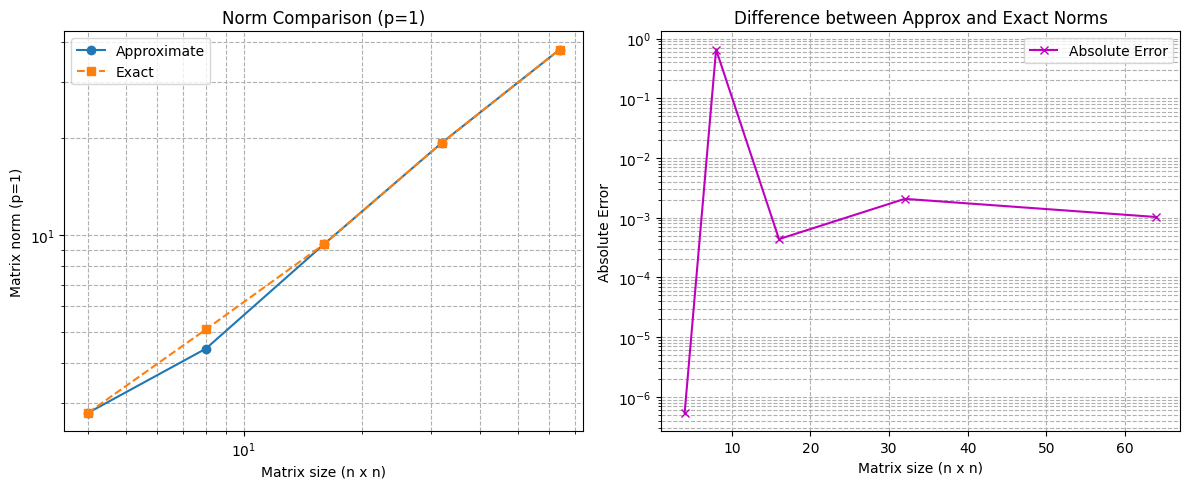

In [13]:
sizes = [2**i for i in range(2,7)]

p = 1
approx_norms = []
exact_norms = []

for size in sizes:
    A = np.random.rand(size, size)
    approx_norm = norm_p(A, p)
    exact_norm = norm_1(A)

    approx_norms.append(approx_norm)
    exact_norms.append(exact_norm)
plot_norm_comparison(sizes, approx_norms, exact_norms, p)

### **$p=2$**

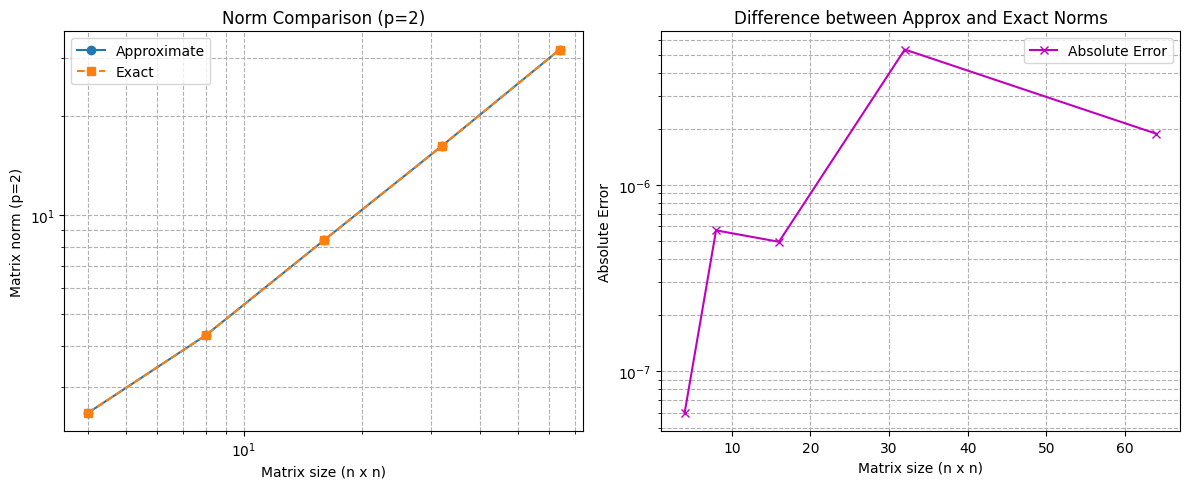

In [14]:
p = 2
approx_norms = []
exact_norms = []

for size in sizes:
    A = np.random.rand(size, size)
    approx_norm = norm_p(A, p)
    exact_norm = norm_2(A)

    approx_norms.append(approx_norm)
    exact_norms.append(exact_norm)
    
plot_norm_comparison(sizes, approx_norms, exact_norms, p)

### **$p=\infty$**

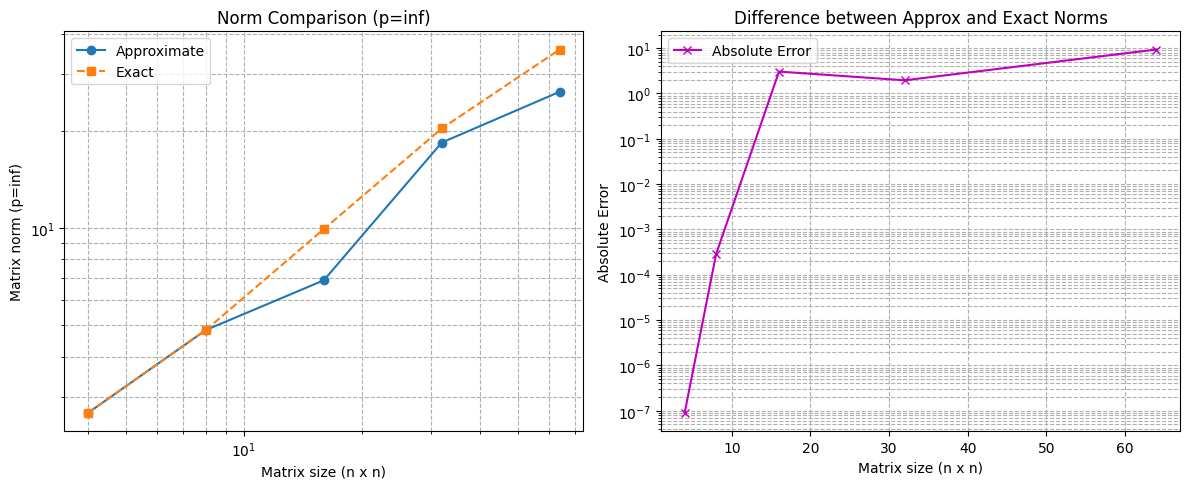

In [15]:
p = np.inf
approx_norms = []
exact_norms = []

for size in sizes:
    A = np.random.rand(size, size)
    approx_norm = norm_p(A, p)
    exact_norm = norm_inf(A)

    approx_norms.append(approx_norm)
    exact_norms.append(exact_norm)

plot_norm_comparison(sizes, approx_norms, exact_norms, p)

## **Wartości kolejnych norm dla macierzy losowej 32x32**

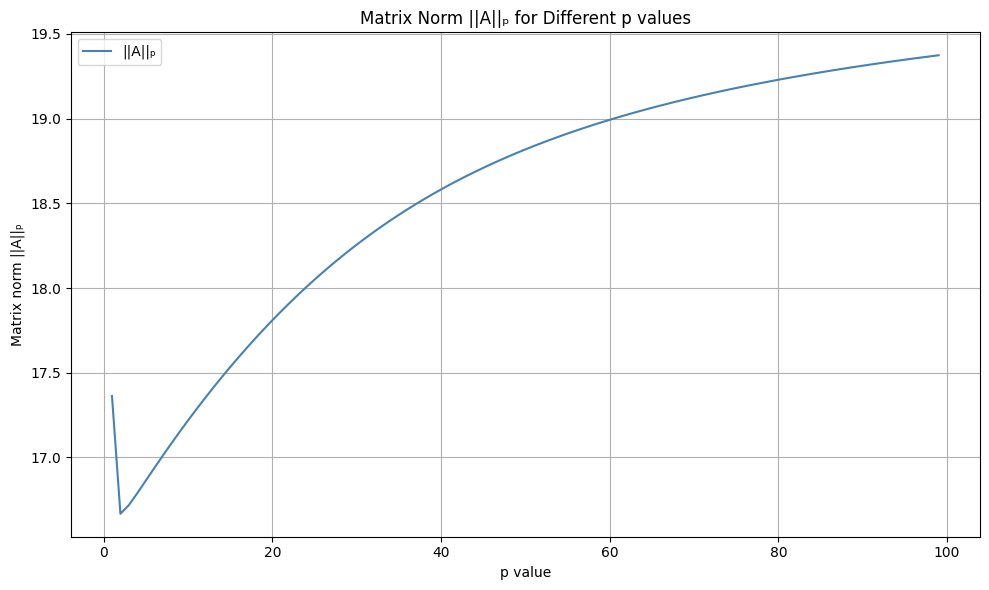

In [21]:
A = np.random.rand(32,32)
ps = [i for i in range(1, 100)]


norms = []
for p in ps:
    norm = norm_p(A, p)
    norms.append(norm)

plt.figure(figsize=(10,6))
plt.plot(ps, norms, label='||A||ₚ', color='steelblue')
plt.xlabel('p value')
plt.ylabel('Matrix norm ||A||ₚ')
plt.title('Matrix Norm ||A||ₚ for Different p values')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()